In [ ]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import ndcg_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: Reading the ground truth and Creating a Mini Test Dataset

## Defining the Directory containing the images and reading my dataframe

In [ ]:
# images
dataset_directory = '/content/drive/MyDrive/test_dataset/'

# where i save my best models
model_path = "/content/drive/MyDrive/Resnet_Finetuned/"

# GT
dataset_path = '/content/drive/MyDrive/donnees_IS_new.xlsx - Sheet1.csv'
df = pd.read_csv(dataset_path)

# Step 2: Pre processing and loading our datasets

## Process the Dataset and Splitting data into train, val, and test



In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

def df_to_image_classes(df):
    image_classes = {}
    for index, row in df.iterrows():
        # Ensure the first item is a string in case of mistakes
        if isinstance(row.iloc[0], str):
            ref_image = dataset_directory + row.iloc[0].strip()
        else:
            continue

        similar_images = []
        for img in row.iloc[1:].dropna():
            if isinstance(img, str):
                img_path = dataset_directory + img.strip()
                similar_images.append(img_path)
                # print(f"Processed image path: {img_path}")

        image_classes[ref_image] = similar_images
    return image_classes


image_classes = df_to_image_classes(df)

print("Number of classes: " , len(image_classes))

Number of classes:  71


## Creating a Custom Dataset Class for our dataset

In [ ]:
class SceneDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = []
        self.labels = []
        self.label_map = {ref_image: idx for idx, ref_image in enumerate(data.keys())}
        for ref_image, similar_images in data.items():
            for img in similar_images:
                self.data.append(img)
                self.labels.append(self.label_map[ref_image])
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


## Defining Data Augmentations and Applying necessary transformations



In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Data Loaders: Preparing for training

In [ ]:
# Datasets
train_dataset = SceneDataset(image_classes, transform=train_transforms)
val_dataset = SceneDataset(image_classes, transform=val_test_transforms)
test_dataset = SceneDataset(image_classes, transform=val_test_transforms)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Step 3: Model Modification for Fine-Tuning

## Loading pre trained resnet 152 and editing the parametres

In [ ]:
model = models.resnet152(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(image_classes))  # Number of classes

# Loading the State Dictionary (this is to continue our training)
model.load_state_dict(torch.load(os.path.join(model_path,'resnet_model_epoch_50_loss_5.71.pth')))

# using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Step 4: Training and Validation Loop

Epoch 1/50: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Training Loss=1.35]


Epoch 1/50
Training Loss: 1.3478, Precision: 0.5598, Recall: 0.5813, F1: 0.5438
Validation Loss: 5.1534, Precision: 0.6974, Recall: 0.6010, F1: 0.5949


Epoch 2/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=1.18]


Epoch 2/50
Training Loss: 1.1780, Precision: 0.7017, Recall: 0.7094, F1: 0.6845
Validation Loss: 1.6882, Precision: 0.7353, Recall: 0.5862, F1: 0.5932


Epoch 3/50: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Training Loss=1.13]


Epoch 3/50
Training Loss: 1.1348, Precision: 0.7056, Recall: 0.6798, F1: 0.6696
Validation Loss: 1.1203, Precision: 0.7853, Recall: 0.6601, F1: 0.6576


Epoch 4/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.772]


Epoch 4/50
Training Loss: 0.7718, Precision: 0.7654, Recall: 0.7537, F1: 0.7295
Validation Loss: 1.8859, Precision: 0.6599, Recall: 0.5616, F1: 0.5452


Epoch 5/50: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, Training Loss=0.792]


Epoch 5/50
Training Loss: 0.7925, Precision: 0.7605, Recall: 0.7438, F1: 0.7200
Validation Loss: 0.4978, Precision: 0.8549, Recall: 0.8276, F1: 0.8125


Epoch 6/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.965]


Epoch 6/50
Training Loss: 0.9647, Precision: 0.7540, Recall: 0.7586, F1: 0.7347
Validation Loss: 0.4155, Precision: 0.8709, Recall: 0.8374, F1: 0.8262


Epoch 7/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.836]


Epoch 7/50
Training Loss: 0.8359, Precision: 0.8099, Recall: 0.7685, F1: 0.7664
Validation Loss: 0.5921, Precision: 0.8509, Recall: 0.7833, F1: 0.7812


Epoch 8/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.872]


Epoch 8/50
Training Loss: 0.8719, Precision: 0.8005, Recall: 0.7734, F1: 0.7655
Validation Loss: 0.5152, Precision: 0.8269, Recall: 0.8128, F1: 0.7952


Epoch 9/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.626]


Epoch 9/50
Training Loss: 0.6259, Precision: 0.7968, Recall: 0.8030, F1: 0.7856
Validation Loss: 0.4089, Precision: 0.9052, Recall: 0.8916, F1: 0.8836


Epoch 10/50: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s, Training Loss=0.826]


Epoch 10/50
Training Loss: 0.8264, Precision: 0.7092, Recall: 0.7537, F1: 0.7124
Validation Loss: 0.3254, Precision: 0.9086, Recall: 0.8966, F1: 0.8871


Epoch 11/50: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, Training Loss=0.738]


Epoch 11/50
Training Loss: 0.7377, Precision: 0.7733, Recall: 0.7734, F1: 0.7594
Validation Loss: 0.5139, Precision: 0.8387, Recall: 0.8276, F1: 0.8059


Epoch 12/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.971]


Epoch 12/50
Training Loss: 0.9712, Precision: 0.7532, Recall: 0.7537, F1: 0.7327
Validation Loss: 0.3944, Precision: 0.9002, Recall: 0.8867, F1: 0.8755


Epoch 13/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.844]


Epoch 13/50
Training Loss: 0.8445, Precision: 0.7487, Recall: 0.7635, F1: 0.7398
Validation Loss: 0.4123, Precision: 0.8624, Recall: 0.8473, F1: 0.8355


Epoch 14/50: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Training Loss=0.853]


Epoch 14/50
Training Loss: 0.8530, Precision: 0.8168, Recall: 0.7882, F1: 0.7765
Validation Loss: 0.6207, Precision: 0.8873, Recall: 0.8670, F1: 0.8602


Epoch 15/50: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, Training Loss=0.771]


Epoch 15/50
Training Loss: 0.7713, Precision: 0.8296, Recall: 0.7931, F1: 0.7813
Validation Loss: 2.0681, Precision: 0.7355, Recall: 0.6650, F1: 0.6584


Epoch 16/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.686]


Epoch 16/50
Training Loss: 0.6859, Precision: 0.7905, Recall: 0.7734, F1: 0.7584
Validation Loss: 1.0616, Precision: 0.8086, Recall: 0.7685, F1: 0.7602


Epoch 17/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.906]


Epoch 17/50
Training Loss: 0.9060, Precision: 0.7538, Recall: 0.7438, F1: 0.7194
Validation Loss: 0.4889, Precision: 0.8617, Recall: 0.8571, F1: 0.8405


Epoch 18/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.717]


Epoch 18/50
Training Loss: 0.7174, Precision: 0.7873, Recall: 0.7734, F1: 0.7564
Validation Loss: 0.3231, Precision: 0.9057, Recall: 0.8916, F1: 0.8804


Epoch 19/50: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it, Training Loss=0.734]


Epoch 19/50
Training Loss: 0.7337, Precision: 0.8365, Recall: 0.8079, F1: 0.8029
Validation Loss: 1.2557, Precision: 0.9103, Recall: 0.8670, F1: 0.8681


Epoch 20/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.664]


Epoch 20/50
Training Loss: 0.6639, Precision: 0.7811, Recall: 0.7685, F1: 0.7489
Validation Loss: 1.0396, Precision: 0.9125, Recall: 0.8867, F1: 0.8831


Epoch 21/50: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, Training Loss=0.615]


Epoch 21/50
Training Loss: 0.6153, Precision: 0.8267, Recall: 0.7980, F1: 0.7998
Validation Loss: 0.3262, Precision: 0.9062, Recall: 0.8768, F1: 0.8772


Epoch 22/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.654]


Epoch 22/50
Training Loss: 0.6540, Precision: 0.8076, Recall: 0.7882, F1: 0.7785
Validation Loss: 0.4012, Precision: 0.8813, Recall: 0.8571, F1: 0.8510


Epoch 23/50: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, Training Loss=0.691]


Epoch 23/50
Training Loss: 0.6912, Precision: 0.8039, Recall: 0.7833, F1: 0.7718
Validation Loss: 0.3104, Precision: 0.9044, Recall: 0.9015, F1: 0.8849


Epoch 24/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.606]


Epoch 24/50
Training Loss: 0.6058, Precision: 0.8050, Recall: 0.8079, F1: 0.7879
Validation Loss: 0.3852, Precision: 0.8680, Recall: 0.8522, F1: 0.8439


Epoch 25/50: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Training Loss=0.735]


Epoch 25/50
Training Loss: 0.7351, Precision: 0.7985, Recall: 0.7833, F1: 0.7716
Validation Loss: 0.3731, Precision: 0.8961, Recall: 0.8867, F1: 0.8734


Epoch 26/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.716]


Epoch 26/50
Training Loss: 0.7157, Precision: 0.7900, Recall: 0.7931, F1: 0.7735
Validation Loss: 0.3993, Precision: 0.9248, Recall: 0.8966, F1: 0.8956


Epoch 27/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.682]


Epoch 27/50
Training Loss: 0.6823, Precision: 0.7358, Recall: 0.7340, F1: 0.7115
Validation Loss: 0.3162, Precision: 0.9142, Recall: 0.8818, F1: 0.8832


Epoch 28/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.602]


Epoch 28/50
Training Loss: 0.6017, Precision: 0.8521, Recall: 0.8079, F1: 0.8096
Validation Loss: 0.4058, Precision: 0.9263, Recall: 0.8916, F1: 0.8967


Epoch 29/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.835]


Epoch 29/50
Training Loss: 0.8355, Precision: 0.8134, Recall: 0.8030, F1: 0.7868
Validation Loss: 0.3800, Precision: 0.9173, Recall: 0.9015, F1: 0.8915


Epoch 30/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.648]


Epoch 30/50
Training Loss: 0.6480, Precision: 0.7987, Recall: 0.7931, F1: 0.7757
Validation Loss: 0.4583, Precision: 0.8775, Recall: 0.8473, F1: 0.8389


Epoch 31/50: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s, Training Loss=0.817]


Epoch 31/50
Training Loss: 0.8171, Precision: 0.7821, Recall: 0.7685, F1: 0.7573
Validation Loss: 0.2919, Precision: 0.9371, Recall: 0.8916, F1: 0.9030


Epoch 32/50: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Training Loss=0.868]


Epoch 32/50
Training Loss: 0.8676, Precision: 0.8324, Recall: 0.7833, F1: 0.7883
Validation Loss: 0.4748, Precision: 0.8601, Recall: 0.8522, F1: 0.8323


Epoch 33/50: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it, Training Loss=0.667]


Epoch 33/50
Training Loss: 0.6671, Precision: 0.8095, Recall: 0.7783, F1: 0.7674
Validation Loss: 0.9099, Precision: 0.7728, Recall: 0.7389, F1: 0.7242


Epoch 34/50: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, Training Loss=0.901]


Epoch 34/50
Training Loss: 0.9006, Precision: 0.7412, Recall: 0.7389, F1: 0.7168
Validation Loss: 0.4067, Precision: 0.8952, Recall: 0.8719, F1: 0.8669


Epoch 35/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.853]


Epoch 35/50
Training Loss: 0.8530, Precision: 0.7918, Recall: 0.7734, F1: 0.7609
Validation Loss: 0.5447, Precision: 0.8477, Recall: 0.8128, F1: 0.7991


Epoch 36/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.879]


Epoch 36/50
Training Loss: 0.8790, Precision: 0.7311, Recall: 0.7488, F1: 0.7266
Validation Loss: 0.6350, Precision: 0.8358, Recall: 0.8030, F1: 0.7797


Epoch 37/50: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, Training Loss=0.796]


Epoch 37/50
Training Loss: 0.7960, Precision: 0.8235, Recall: 0.8030, F1: 0.7924
Validation Loss: 0.5087, Precision: 0.8581, Recall: 0.8424, F1: 0.8242


Epoch 38/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.657]


Epoch 38/50
Training Loss: 0.6572, Precision: 0.8097, Recall: 0.8079, F1: 0.7939
Validation Loss: 0.2972, Precision: 0.9240, Recall: 0.8966, F1: 0.8943


Epoch 39/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.613]


Epoch 39/50
Training Loss: 0.6134, Precision: 0.8638, Recall: 0.8276, F1: 0.8215
Validation Loss: 0.5530, Precision: 0.9108, Recall: 0.8719, F1: 0.8720


Epoch 40/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.693]


Epoch 40/50
Training Loss: 0.6926, Precision: 0.8370, Recall: 0.8227, F1: 0.8161
Validation Loss: 0.5204, Precision: 0.9048, Recall: 0.8621, F1: 0.8639


Epoch 41/50: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it, Training Loss=0.613]


Epoch 41/50
Training Loss: 0.6133, Precision: 0.8544, Recall: 0.8227, F1: 0.8146
Validation Loss: 0.2522, Precision: 0.9302, Recall: 0.9064, F1: 0.9035


Epoch 42/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.635]


Epoch 42/50
Training Loss: 0.6352, Precision: 0.8402, Recall: 0.8177, F1: 0.8106
Validation Loss: 0.2710, Precision: 0.9218, Recall: 0.9015, F1: 0.8968


Epoch 43/50: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, Training Loss=0.676]


Epoch 43/50
Training Loss: 0.6761, Precision: 0.7970, Recall: 0.7882, F1: 0.7746
Validation Loss: 0.2999, Precision: 0.8934, Recall: 0.8768, F1: 0.8630


Epoch 44/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.58]


Epoch 44/50
Training Loss: 0.5800, Precision: 0.8072, Recall: 0.8030, F1: 0.7892
Validation Loss: 0.4105, Precision: 0.8815, Recall: 0.8621, F1: 0.8486


Epoch 45/50: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, Training Loss=0.526]


Epoch 45/50
Training Loss: 0.5258, Precision: 0.8471, Recall: 0.8424, F1: 0.8314
Validation Loss: 1.4280, Precision: 0.8987, Recall: 0.8079, F1: 0.8245


Epoch 46/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.591]


Epoch 46/50
Training Loss: 0.5907, Precision: 0.8222, Recall: 0.8030, F1: 0.7936
Validation Loss: 1.5320, Precision: 0.8444, Recall: 0.7488, F1: 0.7608


Epoch 47/50: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Training Loss=0.746]


Epoch 47/50
Training Loss: 0.7464, Precision: 0.8033, Recall: 0.8030, F1: 0.7879
Validation Loss: 0.6898, Precision: 0.8364, Recall: 0.8227, F1: 0.8067


Epoch 48/50: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Training Loss=0.567]


Epoch 48/50
Training Loss: 0.5674, Precision: 0.7829, Recall: 0.8079, F1: 0.7799
Validation Loss: 0.2804, Precision: 0.9133, Recall: 0.9113, F1: 0.8997


Epoch 49/50: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, Training Loss=0.568]


Epoch 49/50
Training Loss: 0.5680, Precision: 0.8796, Recall: 0.8621, F1: 0.8563
Validation Loss: 0.3429, Precision: 0.8957, Recall: 0.8670, F1: 0.8624


Epoch 50/50: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Training Loss=0.658]


Epoch 50/50
Training Loss: 0.6576, Precision: 0.8309, Recall: 0.7980, F1: 0.7918
Validation Loss: 0.3564, Precision: 0.9054, Recall: 0.8522, F1: 0.8543


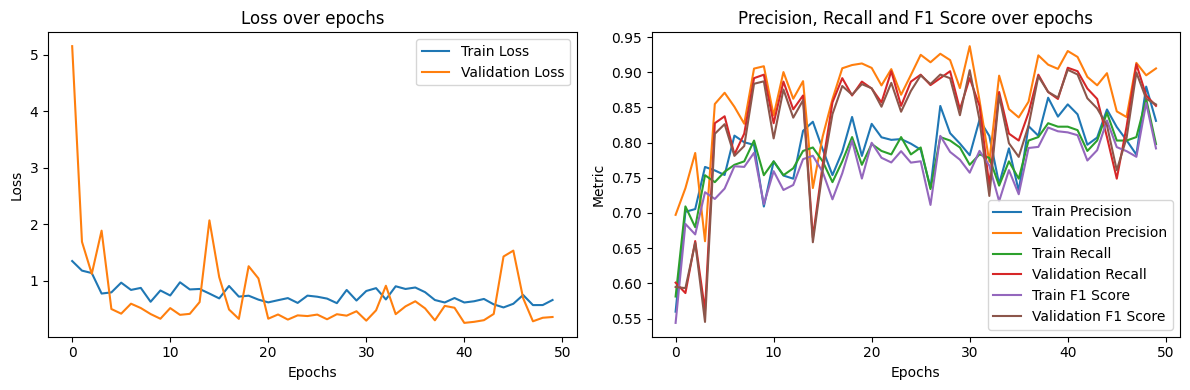

In [ ]:
num_epochs = 50

#  metric history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

for epoch in range(num_epochs):

    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    all_labels, all_preds = [], []

    # progress bar for visualisation
    train_progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}')

    # Training Phase
    for i, (inputs, labels) in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # progress bar
        train_progress_bar.set_postfix({'Training Loss': train_loss / (i+1)})

    # training metrics
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_precision'].append(train_precision)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    all_val_labels, all_val_preds = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())

    # validation metrics
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='weighted', zero_division=0)
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {train_loss / len(train_loader):.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}')
    print(f'Validation Loss: {val_loss / len(val_loader):.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')

    # Saving model after each epoch in case of crash of colab
    model_save_path = os.path.join(model_path, f'resnet_model_epoch_{epoch+1}_loss_{train_loss:.2f}.pth')
    torch.save(model.state_dict(), model_save_path)

## Plotting individual metrics for better understanding

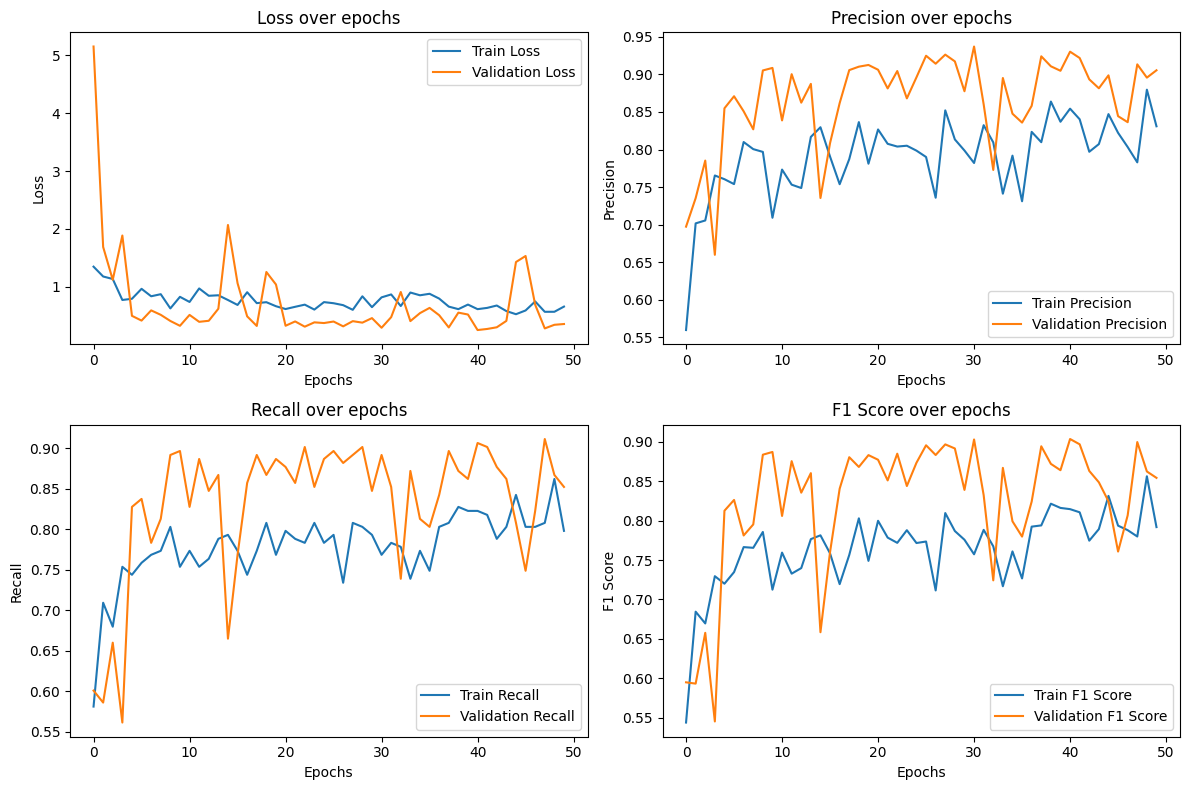

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 8))

# Plotting the loss
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the precision
plt.subplot(2, 2, 2)
plt.plot(history['train_precision'], label='Train Precision')
plt.plot(history['val_precision'], label='Validation Precision')
plt.title('Precision over epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting the recall
plt.subplot(2, 2, 3)
plt.plot(history['train_recall'], label='Train Recall')
plt.plot(history['val_recall'], label='Validation Recall')
plt.title('Recall over epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plotting the F1 score
plt.subplot(2, 2, 4)
plt.plot(history['train_f1'], label='Train F1 Score')
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.title('F1 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


# Step 5: Testing and Evaluation with nDCG Score

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, ndcg_score

def evaluate_model(model, loader, device, k=5):
    model.eval()
    ndcg_scores = []
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.numpy()
            outputs = model(inputs)
            outputs_softmax = torch.softmax(outputs, dim=1)
            outputs_softmax = outputs_softmax.cpu().detach().numpy()

            # scores for nDCG
            relevance_scores = np.zeros_like(outputs_softmax)
            for i, label in enumerate(labels):
                relevance_scores[i, label] = 1

            # nDCG for each instance and append score
            for i in range(outputs_softmax.shape[0]):
                ideal = np.sort(relevance_scores[i])[::-1][:k]
                ndcg = ndcg_score([ideal], [outputs_softmax[i][:k]])
                ndcg_scores.append(ndcg)

            # For precision, recall, F1
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels)
            all_preds.extend(preds.cpu().numpy())

    # Precision, Recall, F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    return np.mean(ndcg_scores), precision, recall, f1

In [ ]:
# Evaluate the model on the test set
ndcg_score, precision, recall, f1 = evaluate_model(model, test_loader, device)
print(f'Test Evaluation - nDCG Score: {ndcg_score}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

Test Evaluation - nDCG Score: 0.4632507048063131, Precision: 0.9054228587986919, Recall: 0.8522167487684729, F1 Score: 0.8542562376943215


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Vizualizing classification results on the mini test dataset

In [ ]:
import matplotlib.pyplot as plt
import torch

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloader, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return


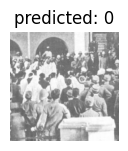

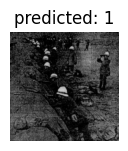

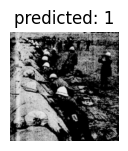

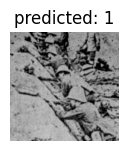

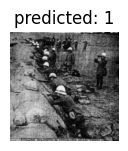

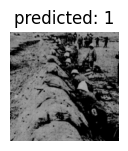

In [ ]:
visualize_model(model, test_loader)
